# Библиотеки

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from sklearn.impute import KNNImputer

пути до файлов

In [8]:
# Загружаем все файлы из папки
folder_path = r"data"
file_list = glob.glob(f"{folder_path}/*.xlsx")
# Загружаем основной файл train.xlsx
train_file = "data/train.xlsx"

In [9]:
main_df = pd.read_excel(train_file)
dataframes = [pd.read_excel(file) for file in file_list if file != train_file]

In [10]:
# Преобразуем дату
main_df['dt'] = pd.to_datetime(main_df['dt'])
main_df['month'] = main_df['dt'].dt.month
main_df['season'] = main_df['month'].map(lambda m: 'Winter' if m in [12, 1, 2] else ('Spring' if m in [3, 4, 5] else ('Summer' if m in [6, 7, 8] else 'Autumn')))

# Добавляем лаговую колонку
lag = 1
target_col = 'Цена на арматуру'
main_df[f'{target_col}_lag{lag}'] = main_df[target_col].shift(lag)

In [11]:
# Объединяем все дополнительные данные по дате
for add_df in dataframes:
    add_df['dt'] = pd.to_datetime(add_df['dt'])
    common_cols = set(main_df.columns) & set(add_df.columns)
    if 'Цена на арматуру' in common_cols:
        add_df.rename(columns={'Цена на арматуру': 'Price_dup'}, inplace=True)
    
    main_df = main_df.merge(add_df, on='dt', how='left', suffixes=(None, '_dup'))
    
    # Убираем дублирующиеся колонки, оставляя только оригинальные
    duplicate_cols = [col for col in main_df.columns if col.endswith('_dup')]
    main_df.drop(columns=duplicate_cols, inplace=True)

In [12]:
# Проверяем реальное название таргета после объединения
target_cols = [col for col in main_df.columns if col.startswith(target_col)]
if not target_cols:
    raise KeyError(f"Колонка с названием, начинающимся на '{target_col}', не найдена в данных")
real_target_col = target_cols[0]

In [13]:
# Удаляем пустые колонки (где пропусков больше 80%)
missing_threshold = 0.8
missing_ratio = main_df.isna().mean()
cols_to_drop = missing_ratio[missing_ratio > missing_threshold].index.tolist()
main_df.drop(columns=cols_to_drop, inplace=True)

In [14]:
# Заполняем пропущенные значения KNN
imputer = KNNImputer(n_neighbors=3)
numeric_cols = main_df.select_dtypes(include=[np.number]).columns
main_df[numeric_cols] = imputer.fit_transform(main_df[numeric_cols])

# Убираем одинаковые колонки
main_df = main_df.loc[:, ~main_df.T.duplicated()]

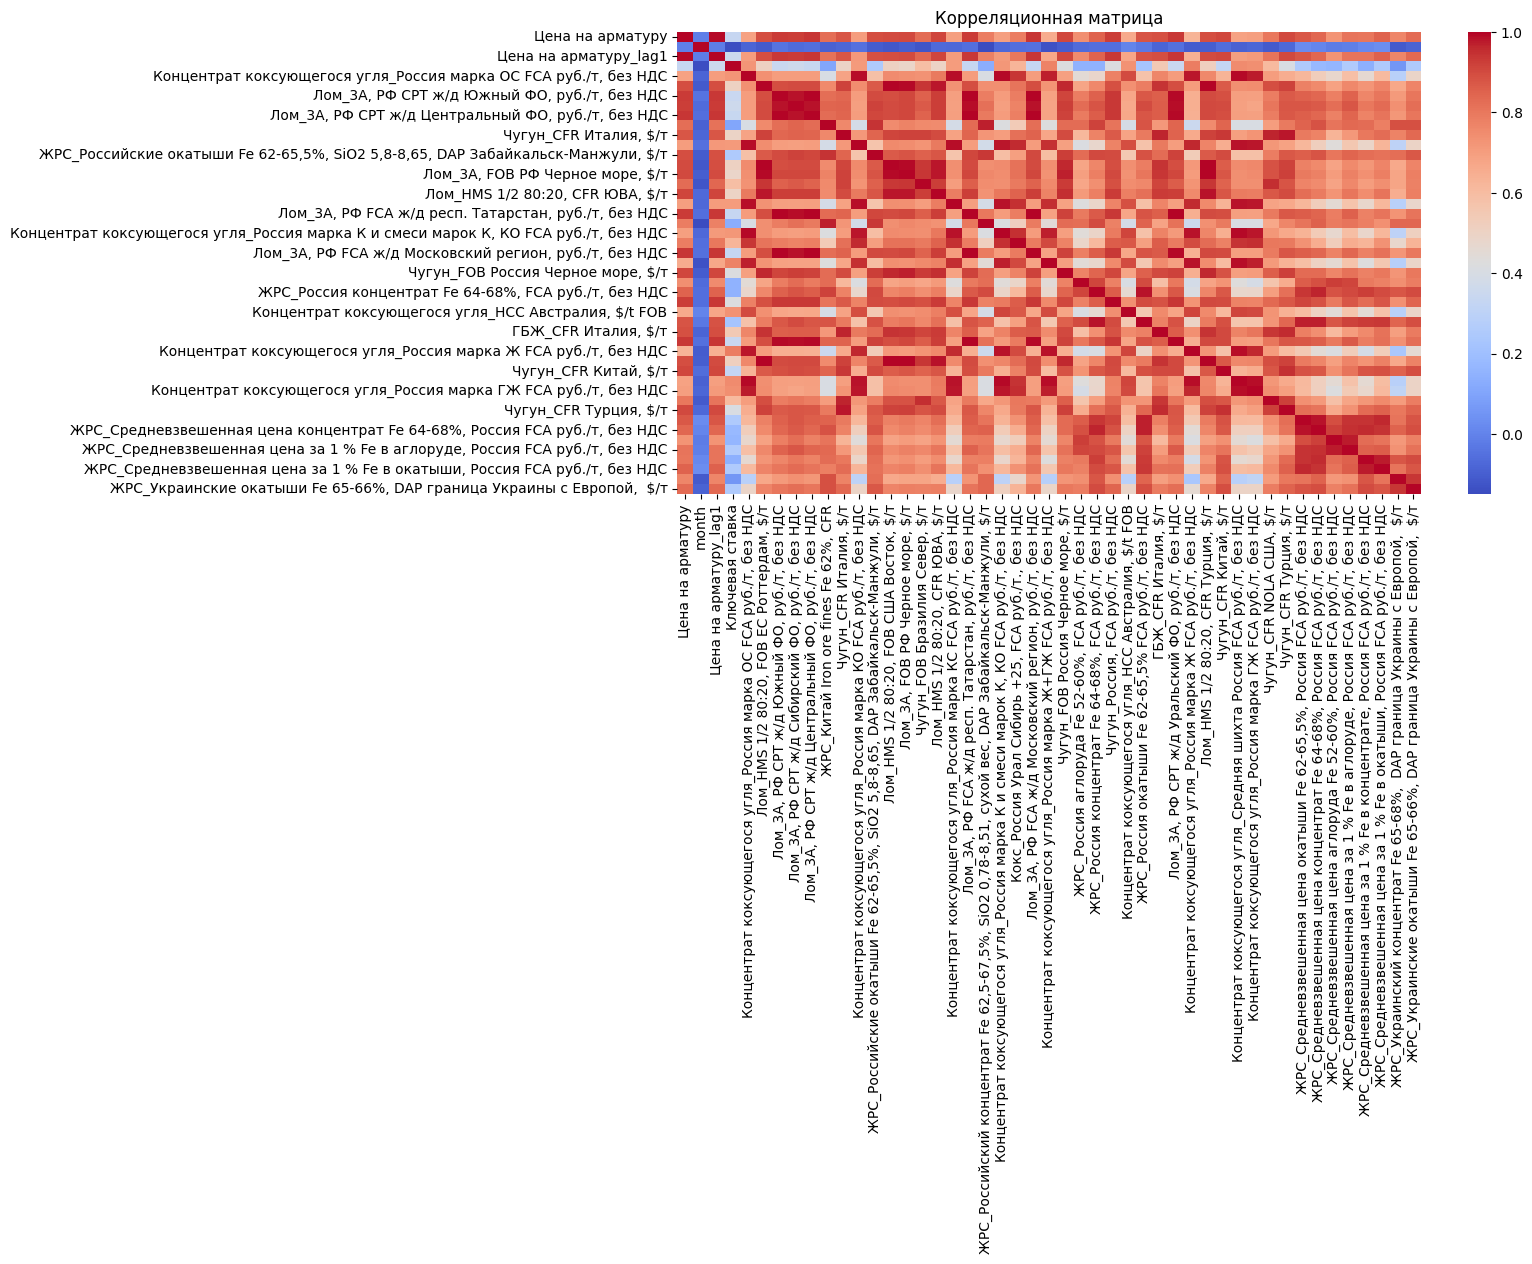

In [15]:
# Строим корреляционную матрицу
plt.figure(figsize=(12, 6))
corr_matrix = main_df.select_dtypes(include=[np.number]).corr()  # Оставляем только числа
sns.heatmap(corr_matrix, annot=False, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

In [16]:
# Определяем наиболее значимые корреляции с таргетом
if real_target_col in corr_matrix.columns:
    target_corr = corr_matrix[real_target_col].dropna()
    strongest_corr = target_corr.abs().sort_values(ascending=False)
    top_features = strongest_corr[1:11]  # Топ-5 без самого таргета
    print("Наиболее значимые корреляции:")
    print(top_features)
else:
    print(f"Ошибка: колонка '{real_target_col}' отсутствует в корреляционной матрице.")

Наиболее значимые корреляции:
Цена на арматуру_lag1                                    0.991984
Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС    0.938009
Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС       0.937741
Лом_3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС         0.934785
Лом_3А, РФ FCA ж/д респ. Татарстан, руб./т, без НДС      0.932665
Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС             0.930566
Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС         0.926161
Чугун_Россия, FCA руб./т, без НДС                        0.924712
Лом_HMS 1/2 80:20, CFR ЮВА, $/т                          0.911623
Чугун_CFR Китай, $/т                                     0.909940
Name: Цена на арматуру, dtype: float64


In [17]:
# Преобразуем дату в нужный формат
main_df['dt'] = main_df['dt'].dt.strftime('%Y-%m-%d')

In [18]:
# Переименовываем колонку Price_x обратно в Price
if 'price_x' in main_df.columns:
    main_df.rename(columns={'price_x': 'price'}, inplace=True)

In [19]:
del main_df['season']
del main_df['month']
main_df.columns = main_df.columns.str.replace(r'\W|_', ' ', regex=True)

In [20]:
# Сохраняем результат в файл Excel
output_file = 'processed_data.xlsx'
main_df.to_excel(output_file, index=False)
print(f"Обработанный файл сохранен как {output_file}")

Обработанный файл сохранен как processed_data.xlsx
